# Análise Avançada dos Dados do Titanic e Criação de Cubos

## Contexto

Você recebeu um dataset contendo informações sobre os passageiros do Titanic. Sua tarefa é analisar os dados de maneira aprofundada, integrando fontes externas, criando um cubo OLAP complexo, e realizando análises preditivas. O objetivo é praticar a modelagem dimensional avançada, a integração de dados e o uso de técnicas de Business Intelligence para insights mais profundos.

## Descrição dos Campos do Dataset do Titanic

Descrição dos Campos do Dataset do Titanic
1. PassengerId:
- Descrição: Identificador único para cada passageiro.
- Tipo: Numérico (inteiro)
- Exemplo: 892
2. Survived:
- Descrição: Indicador de sobrevivência do passageiro (0 = Não sobreviveu, 1 = Sobreviveu).
- Tipo: Numérico (inteiro)
- Exemplo: 1
3. Pclass:
- Descrição: Classe de ticket do passageiro (1 = Primeira classe, 2 = Segunda classe, 3 = Terceira classe).
- Tipo: Numérico (inteiro)
- Exemplo: 3
4. Name:
- Descrição: Nome do passageiro.
- Tipo: Texto (string)
- Exemplo: "Kelly, Mr. James"
5. Sex:
- Descrição: Gênero do passageiro.
- Tipo: Texto (string)
- Exemplo: "male"
6. Age:
- Descrição: Idade do passageiro em anos.
- Tipo: Numérico (decimal)
- Exemplo: 47.0
7. SibSp:
- Descrição: Número de irmãos/cônjuges a bordo com o passageiro.
- Tipo: Numérico (inteiro)
- Exemplo: 1
8. Parch:
- Descrição: Número de pais/filhos a bordo com o passageiro.
- Tipo: Numérico (inteiro)
- Exemplo: 0
9. Ticket:
- Descrição: Número do ticket do passageiro.
- Tipo: Texto (string)
- Exemplo: "330911"
10. Fare:
- Descrição: Tarifa paga pelo passageiro.
- Tipo: Numérico (decimal)
- Exemplo: 78292.0
11. Cabin:
- Descrição: Número da cabine do passageiro.
- Tipo: Texto (string)
- Exemplo: "C85"
12. Embarked:
- Descrição: Porto de embarque do passageiro (C = Cherbourg, Q = Queenstown, S = Southampton).
- Tipo: Texto (string)
- Exemplo: "S"


## Passos

### Passo 1: Exploração Inicial dos Dados

1. Carregue o dataset e visualize as primeiras linhas.

In [1]:
import pandas as pd
import seaborn as sb
from math import ceil, floor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_rows', 500)

In [2]:
df_passenger = pd.read_excel("Exercicio Data Set Titanic.xlsx")
df_passenger.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,345.0,0,0,330911,78292.0,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,96875.0,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,86625.0,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,122875.0,NaN,S


2. Verifique se há valores ausentes e trate-os adequadamente.

In [3]:
df_passenger.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [4]:
df_passenger["Cabin"] = df_passenger["Cabin"].fillna("NA")

def assign_sex(v):
    if (v in ["M", "F"]):
        return v

    sex = str(v).lower()

    if (sex not in ["male", "female"]):
        raise ValueError("Sexo precisa ser 'male' ou 'female'")
    
    return "M" if sex == "male" else "F"

df_passenger["Sex"] = df_passenger["Sex"].apply(assign_sex)

3. Explore as estatísticas descritivas dos dados, como média, mediana, desvio padrão, etc.

In [5]:
df_passenger.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,4.170000e+02
mean,1100.500000,0.363636,2.265550,42.945783,0.447368,0.392344,1.385835e+05
std,120.810458,0.481622,0.841838,61.374513,0.896760,0.981429,4.121475e+05
min,892.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00
25%,996.250000,0.000000,1.000000,22.000000,0.000000,0.000000,2.850000e+02
50%,1100.500000,0.000000,3.000000,29.000000,0.000000,0.000000,2.655000e+03
75%,1204.750000,1.000000,3.000000,42.250000,1.000000,0.000000,7.895800e+04
max,1309.000000,1.000000,3.000000,605.000000,8.000000,9.000000,5.123292e+06


### Passo 2: Limpeza e Transformação dos Dados

1.	Substitua valores ausentes de acordo com a estratégia escolhida (média, mediana, valor fixo, etc.).

In [6]:
df_passenger_agg = df_passenger.groupby(["Pclass", "Sex"])

def get_aggval_group(df, col, arr, fun = "mean"):
    try:
        return df[col].agg(fun).loc[*arr]
    except KeyError:
        return None
    
df_passenger["Fare"] = df_passenger.apply(
    lambda row: int(get_aggval_group(
        df_passenger_agg, "Fare", [row["Pclass"], row["Sex"]]
    )) if pd.isnull(row["Fare"]) else row["Fare"],
    axis = 1
)

df_passenger["Age"] = df_passenger.apply(
    lambda row: int(get_aggval_group(
        df_passenger_agg, "Age", [row["Pclass"], row["Sex"]]
    )) if (pd.isnull(row["Age"]) or row["Age"] > 110) else row["Age"],
    axis = 1
)

2.	Crie novas colunas a partir das existentes, como:
- Faixa etária (crianças, adolescentes, adultos, idosos)
- Família a bordo (com base em SibSp e Parch)

In [7]:
def assign_faixa_etaria(col):
    arr_intervalos = [0, 12, 18, 65, 200]
    arr_labels = ['criança', 'adolescente', 'adulto', 'idoso']
    return pd.cut(col, arr_intervalos, labels=arr_labels)

df_passenger["FaixaEtaria"] = assign_faixa_etaria(df_passenger["Age"])
df_passenger["FamiliaABordo"] = (df_passenger["SibSp"] + df_passenger["Parch"] > 0).astype(int)

3.	Converta colunas categóricas em numéricas, se necessário, para facilitar a análise.

In [8]:
for col in ["Embarked", "Sex"]:
    df_passenger[col] = df_passenger[col].astype("category")

4.	Normalize ou padronize as colunas de valores numéricos.

In [9]:
normalizer = preprocessing.StandardScaler()

In [10]:
# normalized_values = normalizer.fit_transform(df[["Age", "Fare"]])

### Passo 3: Análise Exploratória de Dados (EDA)

1.	Crie gráficos para visualizar a distribuição dos dados, como:
- Histograma da idade
- Gráfico de barras para classe (Pclass)
- Gráfico de barras para sobrevivência (Survived)

<Axes: >

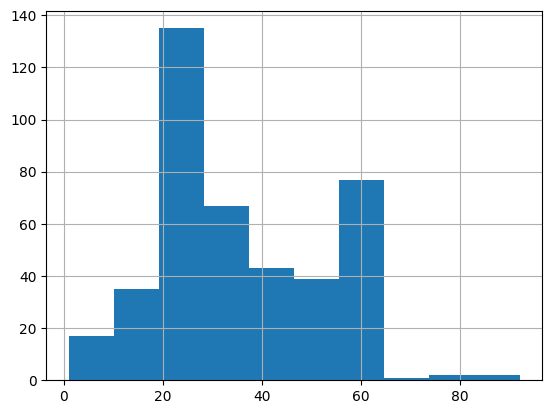

In [11]:
df_passenger["Age"].hist()

<Axes: title={'center': 'DataFrame Plot'}, xlabel='Pclass'>

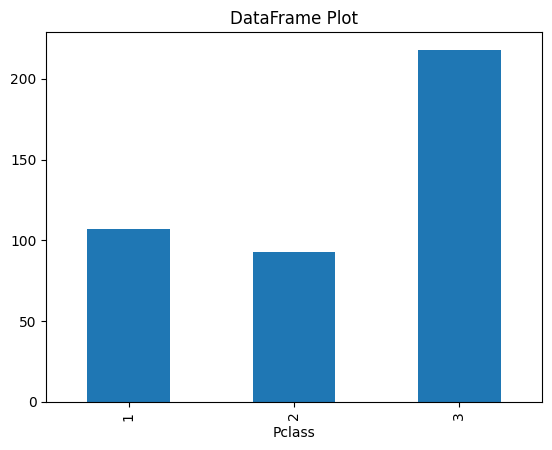

In [12]:
df_passenger.groupby(["Pclass"])["PassengerId"].agg("count").plot(
    kind="bar",
    title="DataFrame Plot"
)

<Axes: title={'center': 'DataFrame Plot'}, xlabel='Survived'>

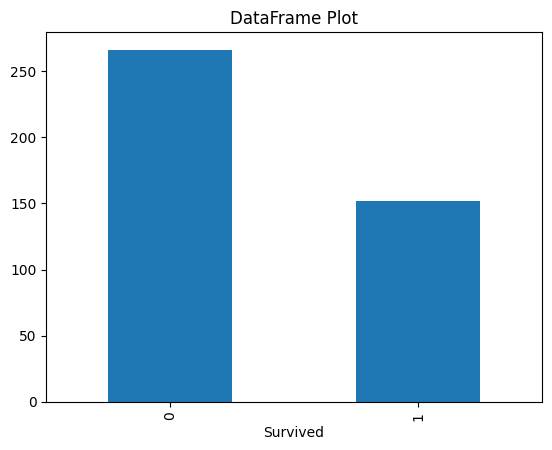

In [13]:
df_passenger.groupby(["Survived"])["PassengerId"].agg("count").plot(
    kind="bar",
    title="DataFrame Plot"
)

2.	Analise a correlação entre variáveis, como a relação entre a classe do passageiro e a taxa de sobrevivência.

In [14]:
df_passenger.corr()

C:\Users\marcu\AppData\Local\Temp\ipykernel_26068\932538029.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_passenger.corr()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamiliaABordo
PassengerId,1.000000,-0.023245,-0.026751,-0.013988,0.003818,0.043080,0.022896,0.000629
Survived,-0.023245,1.000000,-0.108615,-0.225806,0.099943,0.159120,0.152042,0.244187
Pclass,-0.026751,-0.108615,1.000000,-0.161926,0.001087,0.018721,-0.342111,-0.173555
Age,-0.013988,-0.225806,-0.161926,1.000000,-0.070854,-0.032844,0.123320,-0.031778
SibSp,0.003818,0.099943,0.001087,-0.070854,1.000000,0.306895,0.033191,0.618483
Parch,0.043080,0.159120,0.018721,-0.032844,0.306895,1.000000,0.019637,0.495618
Fare,0.022896,0.152042,-0.342111,0.123320,0.033191,0.019637,1.000000,0.167603
FamiliaABordo,0.000629,0.244187,-0.173555,-0.031778,0.618483,0.495618,0.167603,1.000000


In [15]:
df_passenger.corr().loc["Survived"].sort_values(ascending=False)

C:\Users\marcu\AppData\Local\Temp\ipykernel_26068\2011518385.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_passenger.corr().loc["Survived"].sort_values(ascending=False)


Survived         1.000000
FamiliaABordo    0.244187
Parch            0.159120
Fare             0.152042
SibSp            0.099943
PassengerId     -0.023245
Pclass          -0.108615
Age             -0.225806
Name: Survived, dtype: float64

**Resposta**: Não há forte correlação entre sobrevivência e as demais colunas.

3.	Use técnicas de visualização avançadas, como gráficos de violino, gráficos de densidade e mapas de calor.

<Axes: xlabel='Survived', ylabel='Age'>

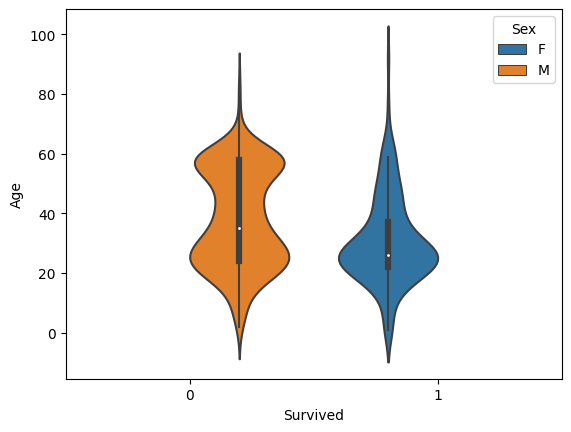

In [16]:
sb.violinplot(x="Survived", y="Age", hue='Sex', data=df_passenger)

<Axes: xlabel='Age', ylabel='Density'>

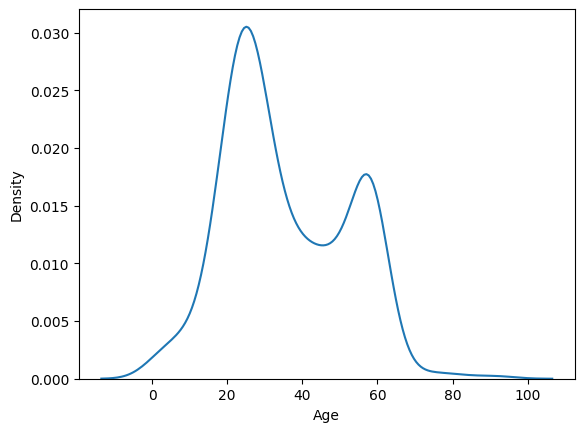

In [17]:
sb.kdeplot(df_passenger, x="Age")

C:\Users\marcu\AppData\Local\Temp\ipykernel_26068\4206958047.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df_passenger.corr(), cmap = "YlGnBu", annot=True, fmt=".2f")


<Axes: >

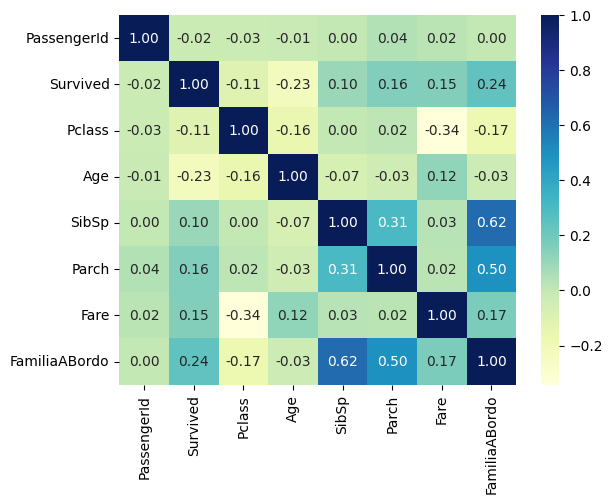

In [18]:
sb.heatmap(df_passenger.corr(), cmap = "YlGnBu", annot=True, fmt=".2f")

### Passo 4: Integração de Fontes Externas

1.	Encontre e integre dados externos relevantes, como informações meteorológicas da noite do naufrágio, detalhes sobre a tripulação ou dados socioeconômicos da época.

**Obs.**:
- Foram incluídos dados da tripulação que estão disponíveis em [Kaggle | Titanic Passengers and Crew Complete List](https://www.kaggle.com/datasets/aliaamiri/titanic-passengers-and-crew-complete-list/data)
- Dados socioeconômicos utilizados disponíveis em [UK Data Service](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=4559)
- Dados meteorológicos utilizados disponíveis em [GitHub | alanjones2/uk-historical-weather](https://raw.githubusercontent.com/alanjones2/uk-historical-weather/main/data/Southampton.csv)

In [19]:
df_se_uk = pd.read_table("input/socioeconomic/occ_1911_lg_t.tab")
df_se_uk = df_se_uk[
    (df_se_uk["occupation"].isin([
        "TOTAL OCCUPIED AND UNOCCUPIED.",
        "Retired or Unoccupied (Order XXIII.)"
    ]) &
    (df_se_uk["adm_cnty"] == "ENGLAND AND WALES")
)].reset_index()

df_se_uk["fg_occupied"] = df_se_uk["occupation"].apply(lambda x: int("total occupied" in str(x).lower()))
df_se_uk = df_se_uk.rename(columns={"adm_cnty": "area"})


df_se_scot = pd.read_table("input/socioeconomic/occ_1911_s.tab")
df_se_scot = df_se_scot[
    (df_se_scot["occupation"].isin([
        "Total Occupied (Orders I.-XXII.)",
        "Total of Unspecified or No Occupation (Order XXIII.)"
    ]) &
    (df_se_scot["area_type"] == "Nation")
)].reset_index()

df_se_scot["fg_occupied"] = df_se_scot["occupation"].apply(lambda x: int("occupied" in str(x).lower()))
df_se_scot = df_se_scot.rename(columns={"sco_cnty": "area"})

In [20]:
df_weather = pd.read_csv(
    "input/weather.csv",
    sep=",",
    index_col=0
)

In [21]:
df_crew = pd.read_csv("input/titanic.csv", sep=",")

df_crew["fg_crew"] = df_crew["class"].apply(lambda x: int("crew" in x or "staff" in x))
df_crew = df_crew.rename(columns={
    "name": "Name",
    "gender": "Sex",
    "age": "Age",
    "class": "Pclass",
    "embarked": "Embarked",
    "ticketno": "Ticket",
    "fare": "Fare",
    "sibsp": "SibSp",
    "parch": "Parch",
    "survived": "Survived"
})
df_crew["Sex"] = df_crew["Sex"].apply(assign_sex)
df_crew["country"] = df_crew["country"].fillna("NA")
df_crew["Ticket"] = df_crew["Ticket"].fillna("NA")
df_crew["SibSp"] = df_crew["SibSp"].fillna(0)
df_crew["Parch"] = df_crew["Parch"].fillna(0)
df_crew["Survived"] = df_crew["Survived"].apply(lambda x: int(x == "yes"))

df_crew["Fare"] = df_crew.apply(
    lambda row: 0 if ("crew" in row["Pclass"] or "staff" in row["Pclass"]) else row["Fare"],
    axis = 1
)

df_crew["situacao"] = df_crew["Pclass"]
df_crew["Pclass"] = df_crew.apply(
    lambda row: 0 if row["fg_crew"] == 1 else int(row["Pclass"][:1]), 
    axis = 1
)

df_crew_agg = df_crew.groupby(["Pclass", "Sex"])

df_crew["Fare"] = df_crew.apply(
    lambda row: get_aggval_group(
        df_crew_agg, "Fare",[row["Pclass"], row["Sex"]]
    ) if pd.isnull(row["Fare"]) else row["Fare"],
    axis = 1
)

df_crew["Age"] = df_crew.apply(
    lambda row: get_aggval_group(
        df_crew_agg, "Age", [row["Pclass"], row["Sex"]]
    ) if pd.isnull(row["Age"]) else row["Age"],
    axis = 1
)

df_crew["FaixaEtaria"] = assign_faixa_etaria(df_crew["Age"])
df_crew["Cabin"] = "NA"
df_crew["FamiliaABordo"] = (df_crew["SibSp"] + df_crew["Parch"] > 0).astype(int)
df_crew["PassengerId"] = 0

cols_to_merge = ["Name", "Age", "Embarked"]
df_passenger = df_passenger.merge(
    df_crew.set_index(cols_to_merge)[["country", "fg_crew"]],
    how="left",
    right_index=True,
    left_on=cols_to_merge
)

df_passenger["fg_crew"] = df_passenger["fg_crew"].fillna(0)
df_passenger["fg_crew"] = df_passenger["fg_crew"].fillna(0)

2.	Combine esses dados com o dataset do Titanic para enriquecer a análise.

In [22]:
df_passenger["data_origin"] = "initial dataset"
df_crew["data_origin"] = "crew dataset"

df_combined = pd.concat(
    [df_passenger, df_crew[df_passenger.columns]]
).drop_duplicates([
    "Name",
    "Sex",
    "Age"
], keep="first")

LAST_ID = df_combined["PassengerId"].max()
def get_new_id():
    global LAST_ID
    LAST_ID += 1
    
    return LAST_ID
    
df_combined["PassengerId"] = df_combined["PassengerId"].apply(lambda x: get_new_id() if x == 0 else x)

### Passo 5: Modelagem Dimensional e Criação de Cubos

1.	Identifique as dimensões e fatos para a criação do cubo. Possíveis dimensões:
- Dimensão Tempo: Ano, Mês, Dia
- Dimensão Passageiro: Idade, Sexo, Classe, Embarque
- Dimensão Ticket: Número do Ticket, Tarifa
- Dimensão Externa: Dados meteorológicos, Socioeconômicos

**Resposta:**

- Dimensão Tempo:
    - Timestamp;
    - Ano;
    - Mês;
    - Dia.

- Dimensão Idade:
    - ID Idade;
    - Idade;
    - Faixa Etária.

- Dimensão Gênero:
    - Gênero.

- Dimensão Ticket:
    - Número do Ticket;
    - Tarifa.

- Dimensão Classe:
    - Classe.

- Dimensão Local de embarque:
    - ID Local de embarque;
    - Porto;
    - Cidade;
    - Condado / província;
    - País.

- Dimensão Cabine:
    - Número da cabine;
    - Fileira;
    - Sala.

- Dimensão dados socioeconômicos:
    - Empregado ou desempregado.

- Dimensão dados meteorológicos:
    - Tempo;
    - Condições de tempo.

- Dimensão Passageiro:
    - Idade;
    - Gênero;
    - Ticket;
    - Classe;
    - Local de Embarque;
    - Cabine;
    - Tinha familiares no barco;
    - Membro da tripulação ou staff;
    - Dados socioeconômicos.

- Dimensão Externa:
    - Dados meteorológicos;
    - Dados socioeconômicos.

- Fato Sobrevivência:
    - ID do Passageiro;
    - Sobreviveu;
    - Dados meteorológicos.

2.	Crie um modelo dimensional (esquema estrela ou floco de neve) baseado nas dimensões identificadas.

**Resposta:** Modelo está no relacionamento do arquivo Power BI.

3.	Use uma ferramenta de BI (como Microsoft Power BI, Tableau, etc.) para criar um cubo OLAP e carregue os dados.

**Resposta:** Modelo construído no Power BI.

4.	Considere a otimização do desempenho do cubo, como a criação de agregados e índices.

**Resposta:** Modelo construído no Power BI.

### O seu cubo precisa responder:

- Qual a taxa de sobrevivência por classe?

**Resposta:**

| **Classe**        | **Sobreviventes** |
|-------------------|-------------------|
| 1ª classe         |       59,7%       |
| 2ª classe         |       39,6%       |
| 3ª classe         |       27,1%       |
| Serviços do Navio |       23,7%       |
| **Total**         |     **32,8%**    |

- Qual a distribuição de idade entre os passageiros que sobreviveram e os que não sobreviveram?

**Resposta:**

| **Classe**   | **Sobreviventes** | **Fatalidades** |
|--------------|-------------------|-----------------|
| Crianças     |       52,1%       |      47,9%      |
| Adolescentes |       35,0%       |      65,0%      |
| Adultos      |       32,4%       |      67,6%      |
| Idosos       |       20,9%       |      79,1%      |
| **Total**    |     **32,8%**     |    **67,2%**    |

- Como a tarifa do ticket influencia a sobrevivência?


**Resposta:** Quanto mais alta a tarifa, maior a chance de sobrevivência.

- Qual o impacto das condições meteorológicas na sobrevivência?

**Resposta:** Os dados utilizados sobre as condições meteorológicas não foram capazes de responder essa pergunta, uma vez que todas as pessoas envolvidas enfrentaram as mesmas condições.

- Crie relatórios e dashboards que visualizam essas análises.

**Resposta:** Modelo construído no PowerBI.

- Otimize as consultas OLAP para melhorar o desempenho.

**Resposta:** Realizado com auxílio do Excel e processamento no Pandas.


### Passo 7: Análise Preditiva

1.	Utilize técnicas de machine learning para criar um modelo preditivo que estime a probabilidade de sobrevivência dos passageiros.
- Divida os dados em conjunto de treino e teste.
- Utilize algoritmos como regressão logística, árvores de decisão ou redes neurais.
- Avalie o modelo usando métricas apropriadas (acurácia, precisão, recall, F1-score).

In [29]:
df_people = pd.read_csv(
    "cubo/data/people.csv",
    sep=";",
    decimal=","
)

df_people["Embarked"] = df_people["Embarked"].map({
    "S": 0,
    "C": 1,
    "B": 2,
    "Q": 3,
})
df_people["FaixaEtaria"] = df_people["FaixaEtaria"].map({
    "criança": 0,
    "adolescente": 1,
    "adulto": 2,
    "idoso": 3,
})
df_people["Age"] = df_people["Age"].astype(float)

for col in [
    "Name",
    "Sex",
    "Cabin",
    "country",
    "Ticket",
    "data_origin",
    "PassengerId"
]:
    del df_people[col]
    
train_df, test_df = train_test_split(df_people, test_size=0.2)

X_train = train_df
Y_train = train_df["Survived"]
X_test  = test_df

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc = round(logreg.score(X_train, Y_train) * 100, 2)

print("Acurácia do modelo de Regressão Logística: " + str(acc) + "%")


Acurácia do modelo de Regressão Logística: 97.14%


c:\Users\marcu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
